In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./grav.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
dtInCU = 2500.0
bigT = 20000

Solving for a pure boson star
Big Lambda: 10000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.767468
A2 (0.001-15.0, check if too close to boundary values): 0.501929
Furthest solved star: 17284.9
n0: 0.00325606
MCU 0.09999071569440995
FAR POINT: 383735 500000


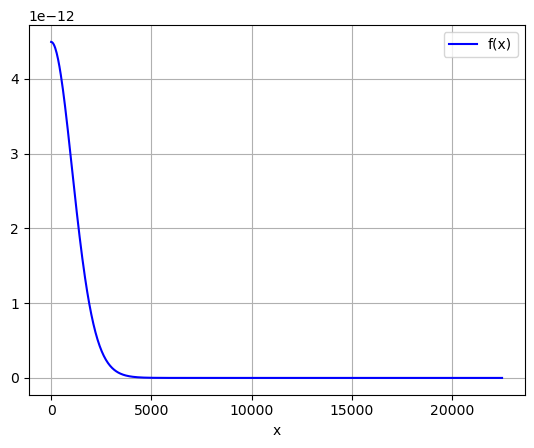

(363,)


In [2]:
allThings = outputProfile(massInCU, aInCU, totalMassInCU, 500)
#Hot Fix
x = allThings["x"][1::2]
psi = allThings["profile"][1::2]

dx = x[1]-x[0]
for i in range(200):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
x = np.concatenate((np.flip(-x), x))

psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
psi = np.concatenate((np.flip(psi), psi))
normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
psi = psi/normalization
psi = psi.astype(complex)

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print(dt)

[0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+0

In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -1.0
            T[i][i+1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i] #What should it be?
            TSph[i][i] = -1.0/2.0/x[i]
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)[size//2:]*np.absolute(psi)[size//2:]
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi)[size//2:])
    my_func.findGravRho(rho_c, phi_c, c_int(size//2), c_double(dx))
    for i in range(size//2):
        place = int(size//2 + i)
        phi[place] = phi_c[i] * GM

    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]
            
        phi[i] = phi[size-i-1] #Regulate

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.058253271016128885 0.9998889830886417
1 0.08351027137908527 0.05826294332248067 0.9998890523321686
2 0.16702054275817055 0.058268368534765996 0.9998890911760075
3 0.2505308141372558 0.058265277729466755 0.9998890690457862
4 0.3340410855163411 0.05825747533813711 0.999889013185747
5 0.4175513568954264 0.05825124711720521 0.9998889686011114
6 0.5010616282745116 0.058248375197552583 0.9998889480441188
7 0.5845718996535969 0.058245659289485434 0.9998889286047787
8 0.6680821710326822 0.058240110918484606 0.9998888888946642
9 0.7515924424117675 0.05823258037430601 0.9998888350040364
10 0.8351027137908528 0.0582258519986606 0.9998887868598401
11 0.9186129851699381 0.05822072741142017 0.9998887501951177
12 1.0021232565490232 0.058215428704405325 0.99988871228802
13 1.0856335279281086 0.05820845555802102 0.9998886624071937
14 1.1691437993071938 0.058200555237625545 0.9998886059012575
15 1.2526540706862792 0.05819336099632633 0.9998885544521255
16 1.3361643420653644 0.058187057692675216 

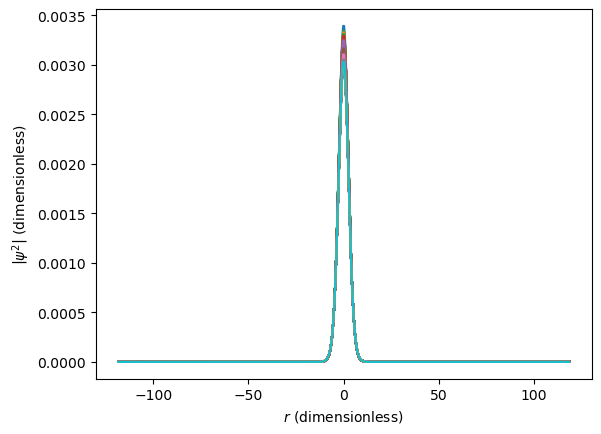

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()


#Record
gravitationalForce = []
pressureGradient = []
quantumPressure = []

hello = []
ts = []
oldGM = GM
newGM = GM*1.05
for t in range(bigT):
    #Pertubation
    #if(t*dt<2.0):
    #    GM = newGM
    #if(t*dt>=2.0):
    #    GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    #Regulate
    for i in range(size//2):
        psi[i] = psi[size-i-1]

    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    if(normalization >= 1.01):
        break
    print(t, t*dt, np.absolute(psi[size//2]), normalization)
    if(GM == oldGM):
        hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
        ts.append(t*dt)

        #Record
        rho0 = (np.absolute(psi[size//2 + 14])*np.absolute(psi[size//2 + 14]))/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[size//2 + 15])*np.absolute(psi[size//2 + 15]))/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[size//2 + 16])*np.absolute(psi[size//2 + 16]))/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[size//2 + 17])*np.absolute(psi[size//2 + 17]))/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        gravitationalForce.append((phi[size//2 + 16]-phi[size//2 + 15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

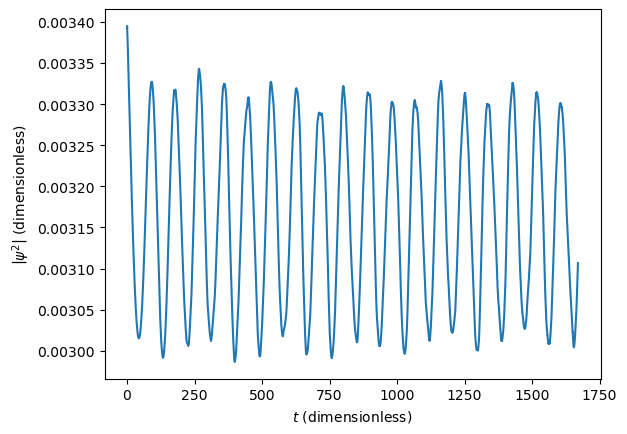

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

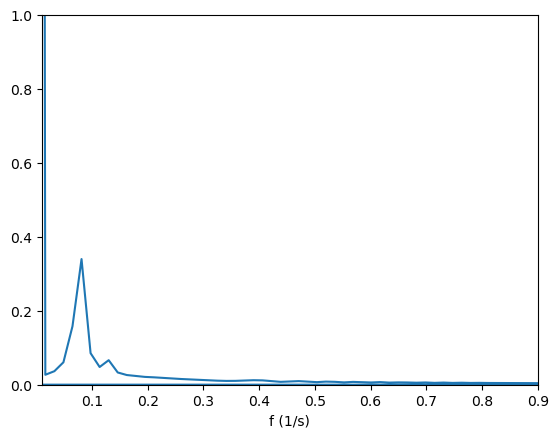

In [9]:
sp = np.fft.fft(hello[:5000])
freq = np.fft.fftfreq(len(hello[:5000]), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.9)
plt.ylim(0.0,1.0)
plt.xlabel("f (1/s)")

In [10]:
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.07 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.08120680000000001 0.33999508373223447


[4.45972919e-07 4.32407680e-07 4.22428346e-07 4.03058506e-07
 3.82440939e-07 3.84728552e-07 4.04620092e-07 4.43718925e-07
 4.91264409e-07 5.42879400e-07 5.83287719e-07 6.11131569e-07
 6.27934725e-07 6.19552102e-07 5.98301457e-07 5.78442604e-07
 5.41935318e-07 5.05060516e-07 4.78094147e-07 4.53301179e-07
 4.46144307e-07 4.63278769e-07 4.91424823e-07 5.30114262e-07
 5.73133712e-07 6.28091704e-07 6.64558022e-07 6.93492825e-07
 7.31245153e-07 7.37162237e-07 7.34819780e-07 7.32587593e-07
 7.32468708e-07 7.28004631e-07 7.30979901e-07 7.52320234e-07
 7.85586371e-07 8.27584936e-07 8.78989932e-07 9.39024750e-07
 1.00509875e-06 1.07424671e-06 1.13671813e-06 1.20812024e-06
 1.27808798e-06 1.34680394e-06 1.41813988e-06 1.48476293e-06
 1.54141815e-06 1.58115748e-06 1.60898396e-06 1.61367254e-06
 1.60035142e-06 1.56399733e-06 1.49202790e-06 1.41024694e-06
 1.30467766e-06 1.18944982e-06 1.07471799e-06 9.61745612e-07
 8.60284738e-07 7.71160719e-07 7.17545792e-07 6.88080454e-07
 6.87066578e-07 7.197626

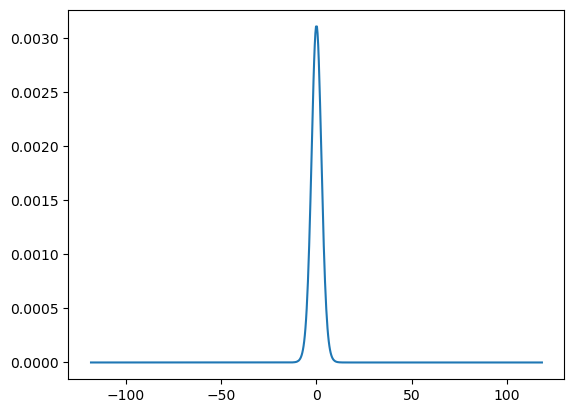

In [11]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?

In [12]:
print(psi)

[ 5.40571573e-08-4.42684614e-07j  6.62821266e-08-4.27297416e-07j
  9.18393569e-08-4.12324193e-07j  1.40499454e-07-3.77777795e-07j
  1.94657739e-07-3.29195135e-07j  2.57199030e-07-2.86120111e-07j
  3.36779951e-07-2.24269220e-07j  4.09194930e-07-1.71598349e-07j
  4.77029043e-07-1.17405331e-07j  5.39702609e-07-5.86441506e-08j
  5.83259796e-07-5.70730043e-09j  6.09407374e-07+4.58742572e-08j
  6.21302825e-07+9.10209753e-08j  6.03558067e-07+1.39865892e-07j
  5.69154665e-07+1.84465718e-07j  5.30180145e-07+2.31311177e-07j
  4.68710857e-07+2.72036802e-07j  3.94838340e-07+3.14942551e-07j
  3.20404432e-07+3.54845055e-07j  2.42689197e-07+3.82862786e-07j
  1.49367984e-07+4.20397369e-07j  6.51843301e-08+4.58670057e-07j
 -1.11137271e-08+4.91299136e-07j -8.90173391e-08+5.22586877e-07j
 -1.51371705e-07+5.52782832e-07j -2.15898738e-07+5.89819399e-07j
 -2.65555551e-07+6.09194234e-07j -3.08850480e-07+6.20921637e-07j
 -3.59508742e-07+6.36767570e-07j -4.03820014e-07+6.16715137e-07j
 -4.47358707e-07+5.829496